In [30]:
from aberrations import *
from observer import *
from controller import *
import numpy as np
from scipy import signal, io
from matplotlib import pyplot as plt
%matplotlib inline

delay = 0 # the number of frames of delay already accounted for
f_sampling = 1000

In [2]:
def make_impulse_response(overshoot, t_rise, T=np.arange(0, 1, 0.001)):
    # takes in fractional overshoot and rise time, returns a time-series impulse response satisfying it.
    # damping ratio from OS
    z = (-np.log(overshoot))/(np.sqrt(np.pi**2 + np.log(overshoot)**2))
    # find approximation to t_rise * natural frequency
    w = (1/t_rise) * (1.76 * z**3 - 0.417 * z**2 + 1.039 * z + 1)
    num = [w**2]
    den = [1, 2 * w * z, w**2]
    tf = signal.TransferFunction(num, den)
    impulse = signal.impulse(tf, T=T)
    return impulse[0], impulse[1] / sum(impulse[1])

In [21]:
times, impulse = make_impulse_response(0.5, 0.01)

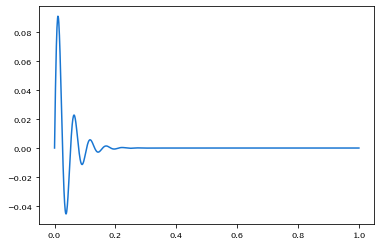

In [22]:
plt.plot(times, impulse)

(1e-12, 0.000539914390279241)

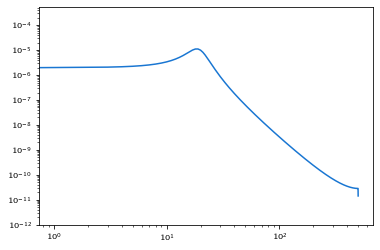

In [23]:
plt.loglog(*signal.periodogram(impulse, fs=f_sampling))
plt.ylim(1e-12)

In [24]:
# next up, data! 
# we're going to use the standard integrator for this, to more closely compare to actual Keck TTs.

stdint = Controller('stdint')
openloops = np.load('../telemetry/sim_openloops_0.npy')
res, act, _ = stdint.control(openloops, noise=0)

Starting at timestep 3


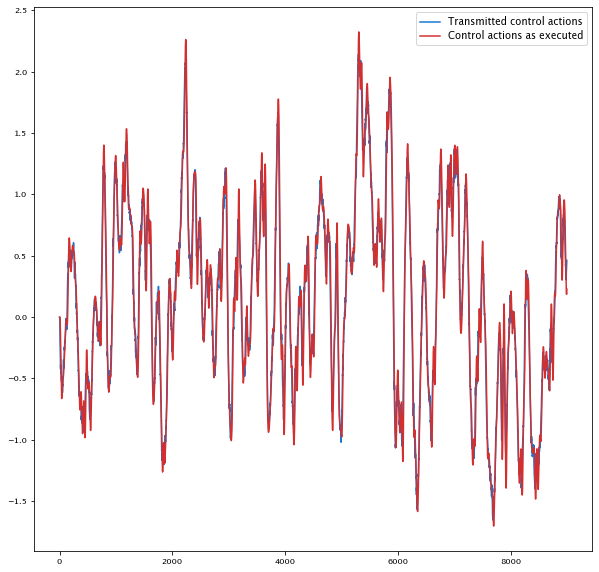

In [26]:
plt.figure(figsize=(10,10))
plt.plot(act, label='Transmitted control actions')
plt.plot(true_actions, label='Control actions as executed')
# plt.plot(true_actions - act, label='Residual action')
plt.legend()

In [27]:
pol = act + true_residuals

(1e-07, 29.141116253323368)

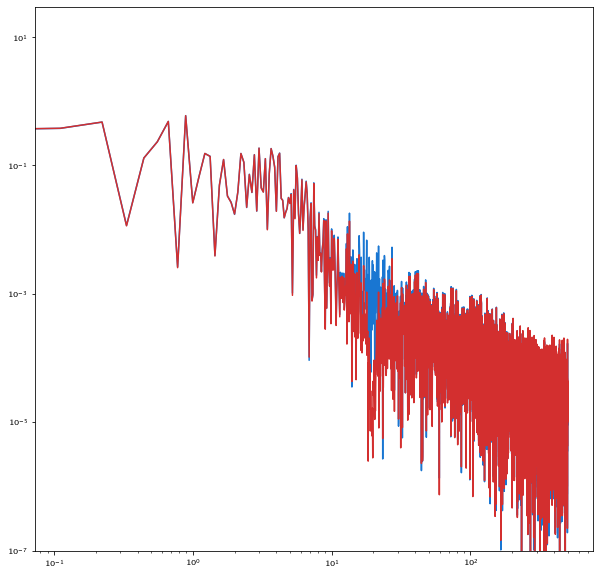

In [28]:
plt.figure(figsize=(10,10))
plt.loglog(*signal.periodogram(openloops, fs=f_sampling), label="Open loops")
plt.loglog(*signal.periodogram(pol, fs=f_sampling), label="Pseudo open loops")
plt.ylim(1e-7)

In [53]:
num = 128
filename = '../telemetry/n0' + str(num) + '_LGS_trs.sav'
telemetry = io.readsav(filename)['a']
commands = deepcopy(telemetry['TTCOMMANDS'][0])
commands = commands - np.mean(commands, axis=0)
residuals = telemetry['RESIDUALWAVEFRONT'][0][:,349:351]

In [54]:
commands

array([[ 0.3298297 , -0.3774805 ],
       [ 0.3297963 , -0.3714342 ],
       [ 0.3303342 , -0.3665533 ],
       ...,
       [-0.03911972,  0.23606348],
       [-0.03802538,  0.23881674],
       [-0.03584385,  0.23964787]], dtype=float32)

In [55]:
keck_pols = commands[:-1] + residuals[1:]

array([[ 0.26971692, -0.38398117],
       [ 0.2806981 , -0.37105888],
       [ 0.2665398 , -0.3809012 ],
       ...,
       [-0.04510951,  0.23984978],
       [-0.06759474,  0.24424869],
       [-0.04844058,  0.25970757]], dtype=float32)

(1e-10, 23.10562931944245)

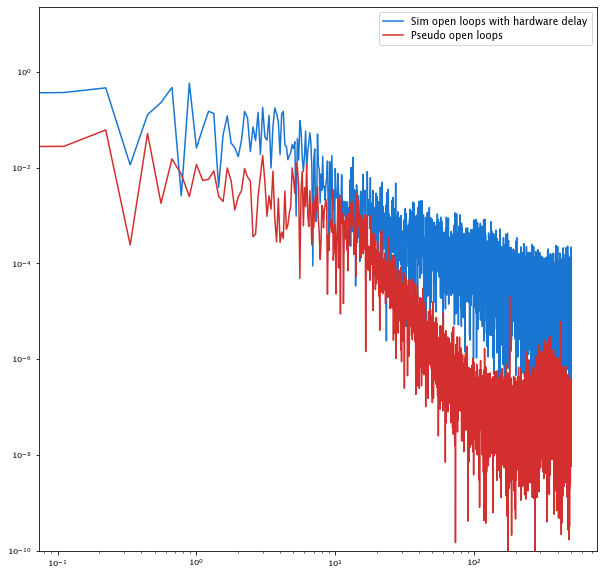

In [73]:
_, impulse = make_impulse_response(0.01, 1e-5)
true_actions = np.convolve(act, impulse)[:len(act)]
true_residuals = openloops - true_actions
pol = act + true_residuals
plt.figure(figsize=(10,10))
plt.loglog(*signal.periodogram(pol, fs=f_sampling), label="Sim open loops with hardware delay")
plt.loglog(*signal.periodogram(keck_pols[:len(pol),0], fs=f_sampling), label="Pseudo open loops")
plt.legend()
plt.ylim(1e-10)

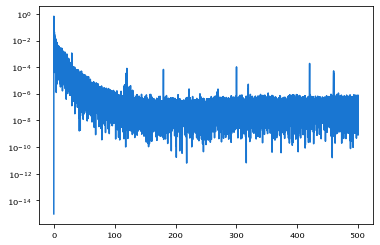

In [71]:
f, P = signal.periodogram(keck_pols[:,1], fs=f_sampling)
plt.semilogy(f, P)